In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
from sklearn import linear_model

In [ ]:
!python -m pip install pooch # You might need to run this once
                             # and then you can delete it..
                             # Needed for Problem 3.

## Background

So things probably went a little quick via the Zoom lecture, so we'll collect some critical information here that we'll use later in the assignment.  

> **Dictionary Learning**: Given data $n\times m$ real-value data matrix $Y$, we want to find a $n\times p$ _dictionary_ $A_{\ast}$ and sparse encoding of $Y$, say $p\times m$ $Z_{\ast}$ which solves
$$
A_{\ast}, Z_{\ast} = \text{arg min}_{A, Z} \left|\left|Y-AZ\right|\right|_{F} + \lambda \left|\left|Z\right|\right|_{1}, ~ \lambda > 0.
$$
Each column of $A$ is called an _atom_.  We seek _overcomplete_ dictionaries so that $n<p$, and to make the problem more tractable, we should have even more data than we have atoms so that $n<p<m$.  

> **Greedy Algorithms**: To solve
$$
\text{min}_{A, Z} \left|\left|Y-AZ\right|\right|_{F} + \lambda \left|\left|Z\right|\right|_{1}
$$
we make an initial guess for $A_{0}$ and then solve in two stages:
\begin{align*}
\text{Find} ~ Z_{1} = & \text{arg min}_{Z} \left|\left|Y-A_{0}Z\right|\right|_{F} + \lambda \left|\left|Z\right|\right|_{1} \\
\text{Find} ~ A_{1} = & \text{arg min}_{A} \left|\left|Y-AZ_{1}\right|\right|_{F}.      
\end{align*}
Repeat then until you get convergence.  


> **Computing $D_{A}\left|\left|Y-AZ\right|\right|_{F}^{2}$**: So if we define the function $f(A)=\left|\left|Y-AZ\right|\right|_{F}^{2}$, then we can find its directional derivative at $A$ with respect to the direction $W$, denoted as $<D_{A}f(A), W>=\text{tr}((D_{A}f(A))^{T}W)$, via the formula:
$$
<D_{A}f(A), W> = \lim_{\epsilon\rightarrow 0}\frac{f(A+\epsilon W) - f(A)}{\epsilon} = \left<-2Z(Y-AZ)^{T}, W\right>
$$
Thus, if we want to find $A_{\ast}$ such that $D_{A}f(A)|_{A=A_{\ast}}=0$, then we see that $A_{\ast}$ solves
$$
Z(Y-A_{\ast}Z)^{T} = 0 \implies A_{\ast}ZZ^{T} = YZ^{T}.
$$

> **Moore-Penrose Pseudoinverse**: If for the $p\times m$ real-valued matrix $Z$ we have $\text{rank}(Z)=p$ (remember $p<m$), then we can find the rank-reduced SVD of $Z$ which is $Z = U\Sigma_{p}V_{p}^{T}$ where $\Sigma_{p}$ is $p\times p$ and has strictly positive diagonal entries so $\Sigma_{p}^{-1}$ exists.  Our full rank condition ensures that $U^{T}U=UU^{T}=I$, but we only have $V_{p}^{T}V_{p}=I$ with $V_{p}V_{p}^{T}$ in general being a projection matrix, not the identity. We then see that
$$
ZZ^{T} = U\Sigma_{p}^{2}U_{p}^{T}
$$
is of full rank and thus invertible.  Therefor the problem
$$
A_{\ast}ZZ^{T} = YZ^{T}
$$
can now be written as
$$
A_{\ast} = YZ^{-P} = YV_{p}\Sigma_{p}^{-1}U^{T}.
$$

**Problem 1** (Graduate): Since there was so much interest in this problem, I'll have y'all work it out.  So, suppose that, for ${\bf y}, {\bf z} \in \mathbb{R}^{n}$ we want to solve

$$
{\bf z}_{\ast} = \text{arg min}_{{\bf z}} ~ \left|\left|{\bf y} - A{\bf z}\right|\right|_{2}^{2} + \lambda \left|\left|{\bf z}\right|\right|_{1}
$$

where $\lambda > 0$ and for real-valued, square $A$, $A^{T}A = AA^{T} = I$.  Letting ${\bf u} = A^{T}{\bf y}$, show that

$$
z_{\ast,l} = \left\{
\begin{array}{rl}
u_{l} - \frac{\lambda}{2} & u_{l} > \frac{\lambda}{2} \\
0 & |u_{l}| \leq \frac{\lambda}{2} \\
u_{l} + \frac{\lambda}{2} & u_{l} < -\frac{\lambda}{2}
\end{array}
\right.
$$

Show that this multi-part formula can be written in the freakishly compact form

$$
z_{\ast,l} = u_{l}\text{max}\left\{0, 1 - \frac{\lambda}{2|u_{l}|}\right\}
$$

Note, to do all of this, you'll need the sub-differential of $|x|$, $\partial |x|$, where

$$
\partial |x| = \left\{
\begin{array}{rl}
1 & x > 0\\
r\in(-1,1)& x=0, ~ \\
-1 & x < 0
\end{array}
\right.
$$

### Commentary on Problem 1

So again, the big point with this problem is that it gives us a computabible example in which we see how LASSO regularization encourages sparsity.  

**Problem 2**: So guilty confession time, I've been playing a bit fast and loose with norms during lecture, so let's clear that issue up.  First off, for the Frobenius norm, where

$$
\left|\left|A\right|\right|^{2}_{F} = \text{tr}\left(A^{T}A\right) = \text{tr}\left(A A^{T}\right) = \sum_{j=1}^{N_{r}}\sum_{k=1}^{N_{c}}\left|a_{ij}\right|^{2}
$$

* Show for $n\times m$ $Y$, $n\times p$ $A$, and $p\times m$ $Z$ that  
$$
\left|\left|Y - AZ\right|\right|^{2}_{F} = \sum_{l=1}^{m}\left|\left|{\bf y}_{l} - A{\bf z}_{l}\right|\right|^{2}_{2},
$$
where ${\bf y}_{l}$ and ${\bf z}_{l}$ denote the columns of $Y$ and $Z$ respectively.  

So this result shows that any Frobenius norm problem can be thought of essentially as an average across the respective columns of the matrices $Y$ and $Z$ relative to the matrix $A$.  This is why you'll see me swap back and forth between $F$ and the 2-norm without pausing too much.  

My next sin was in writing $\left|\left|Z\right|\right|_{1}$ for general $p\times m$ matrices $Z$.  We've only defined $\left|\left|\cdot\right|\right|_{1}$ for vectors.  To generalize this to matrices, we define

$$
\left|\left|Z\right|\right|_{1} = \text{sup}_{{\bf x}\neq 0} \frac{\left|\left|Z{\bf x}\right|\right|_{1}}{\left|\left|{\bf x}\right|\right|_{1}}
$$

* For ${\bf x}\in \mathbb{R}^{m}$ show that
$$
    \left|\left|Z{\bf x}\right|\right|_{1}\leq \left(\text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1}\right) \left|\left|{\bf x}\right|\right|_{1},
$$
where again ${\bf z}_{l}$ denotes the $l^{th}$-column of $Z$.  Thus we see that
$$
    \left|\left|Z\right|\right|_{1} \leq \text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1}
$$
    
    
* WOLOG, suppose that $\text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1} = \left|\left|{\bf z}_{1}\right|\right|_{1}$.  Show that if we choose ${\bf x} = (1 ~0 \cdots 0)^{T}$ that
$$
\left|\left|Z{\bf x}\right|\right|_{1}  = \text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1},
$$
and thus
$$
\left|\left|Z\right|\right|_{1} = \text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1}
$$

2.1:
\begin{align*}
\|Y - AZ\|^{2}_{F}
&= \text{tr}\left((Y - AZ)^{T}(Y - AZ)\right) \\
&= \text{tr}\left(Z^{T}A^{T}A Z - Z^{T}A^{T}Y - Y^{T}AZ + Y^{T}Y\right) \\
&= \text{tr}\left(Z^{T}A^{T}A Z - Z^{T}A^{T}Y - Y^{T}AZ + Y^{T}Y\right) \\
&= \text{tr}\left(Z^{T}A^{T}A Z\right) - \text{tr}\left(Z^{T}A^{T}Y\right) - \text{tr}\left(Y^{T}AZ\right) + \text{tr}\left(Y^{T}Y\right) \\
&= \text{tr}\left(Z^{T}A^{T}A Z\right) - 2\text{tr}\left(Y^{T}AZ\right) + \text{tr}\left(Y^{T}Y\right) \\
\sum_{l=1}^{m}\|{\bf y}_{l} - A{\bf z}_{l}\|^{2}_{2}
&= \sum_{l=1}^{m}({\bf y}_{l}-A{\bf z}_{l})^T({\bf y}_{l}-A{\bf z}_{l})\\
&= \sum_{j=1}^{m}\sum_{l=1}^{m}\left({\bf y}_{j}^T{\bf y}_{l} - 2{\bf y}_{j}^TA{\bf z}_{l}+{\bf z}_{j}^TA^TA{\bf z}_{l}\right)\\
&= \sum_{j=1}^{m}\sum_{l=1}^{m}\left({\bf z}_{j}^TA^TA{\bf z}_{l}\right) - \sum_{j=1}^{m}\sum_{l=1}^{m}\left(2{\bf y}_{j}^TA{\bf z}_{l}\right) + \sum_{j=1}^{m}\sum_{l=1}^{m}\left({\bf y}_{j}^T{\bf y}_{l}\right)\\
&= \text{tr}\left(Z^{T}A^{T}A Z\right) - 2\text{tr}\left(Y^{T}AZ\right) + \text{tr}\left(Y^{T}Y\right)\\
&= \|Y - AZ\|^{2}_{F}
\end{align*}
Therefore,
$$\|Y - AZ\|^{2}_{F} = \sum_{l=1}^{m}\|{\bf y}_{l} - A{\bf z}_{l}\|^{2}_{2}.$$

2.2:\
First consider that for any non-zero ${\bf x} \in \mathbb{R}^{m}$,

\begin{align*}
\|Z{\bf x}\|_1
&= \sum_{j=1}^p\left|\sum_{l=1}^m z_{jl}x_l\right|\\
&\le \sum_{j=1}^p\sum_{l=1}^m| z_{jl}||x_l|\\
&= \sum_{l=1}^m\left(\sum_{j=1}^p| z_{jl}|\right)|x_l|\\
&= \sum_{l=1}^m \|{\bf z}_l\|_1 |x_l|,~ \|{\bf z}_l\|_1=\left(\sum_{j=1}^p| z_{jl}|\right)\\
&\le \left(\text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1}\right) \sum_{l=1}^m |x_l|\\
&= \left(\text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1}\right) \|{\bf x}\|_1
\end{align*}

Then $\left|\left|Z\right|\right|_{1} \leq \text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1}$.

2.3:
Given ${\bf x} = (1 ~0 \cdots 0)^{T}$, we have $\|{\bf x}\|_1=1$, and
$\|Z{\bf x}\|_1 =\|{\bf z}_1\|_1$.

Therefore, when ${\bf x} = (1, 0, \cdots, 0)^{T}$ is selected, $|Z{\bf x}|_1$ achieves the maximum value $\left|\left| {\bf z}_{1}\right|\right|_{1}$.

Since the ${\bf x}$ we choose is any non-zero vector, the above conclusion holds for all non-zero ${\bf x}$. Therefore, we get
$$
\|{\bf Z}\|_1 = \text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1}
$$

### Commentary on Problem 2

Thus, what you are showing in Problem 2 is that if we want to solve LASSO related problems like

$$
\min_{Z} \left|\left|Y - AZ\right|\right|_{F}, ~ \text{with}~\left|\left|Z\right|\right|_{1}\leq \epsilon,
$$

then this is equivalent to optimizing column-by column, i.e. for all $1\leq l \leq m$, find

$$
\min_{{\bf z}_{l}} \left|\left|{\bf y}_{l} - A{\bf z}_{l}\right|\right|_{2}, ~ \text{with}~ \left|\left|{\bf z}_{l}\right|\right|_{1}\leq \epsilon,
$$

and vice versa.

**Problem 3**: So it shouldn't be surprising that dictionary learning is something that you can do via library calls in Scikit-Learn.  To wit, there is a full tutorial that walks you through the process of using dictionary learning to do image denoising at:

[Noisy Raccoon](https://scikit-learn.org/stable/auto_examples/decomposition/plot_image_denoising.html#sphx-glr-auto-examples-decomposition-plot-image-denoising-py)

As you can readily see, you can (and should) download the Jupyter notebook that implements the process soup-to-nuts.  So me making you recreate all of it is... silly.  

That said, I can ask you questions that hopefully make you crawl through the code line-by line, and of course there is always theory to fuss over, so let's get to it.  Note, please make all changes to code in that notebook, but please report results in this one.  Upload both to your homework folder.  

Anyway, in the code, dictionary learning is done via the function `MiniBatchDictionaryLearning()` which solves:

$$
\min_{A, Z} \left|\left|Y - AZ\right|\right|_{F} + \lambda \left|\left|Z\right|\right|_{1, 1}
$$

where

$$
\left|\left|Z\right|\right|_{1, 1} = \sum_{j=1}^{p}\sum_{l=1}^{m}|z_{jl}|
$$

* Show that if $\left|\left|Z\right|\right|_{1, 1} < \epsilon$ then $\left|\left|Z\right|\right|_{1} < \epsilon$.  Likewise, show that if $\left|\left|Z\right|\right|_{1} < \epsilon$ then $\left|\left|Z\right|\right|_{1, 1} < m\epsilon$.  This shows that we aren't introducing anything radically new by using $\left|\left|Z\right|\right|_{1, 1}$.

* In the greedy algorithm approach to solving the dictionary learning problem, given that we find $A_{1}=YZ_{1}^{-P}$, show that
$$
\left|\left|Y - A_{1}Z_{1}\right|\right|_{F} = \left|\left|Y (I - V_{1,p}V_{1,p}^T) \right|\right|_{F} = \left|\left|(I - V_{1,p}V_{1,p}^T) Y\right|\right|_{F}
$$
How could you interpret this result?  

* In the downloaded notebok, keeping the number of atoms used fixed, change the patch size to $14\times 14$.  Report any differences in the results and try to explain them.  
* In the downloaded notebok, keeping the number of atoms used fixed, change the patch size to $3\times 3$.  Report any differences in the results and try to explain them.  
* In the downloaded notebok, keeping the patch size fixed to 7, change the number of atoms used to 1 and 10 (instead of 2).  Report any differences in the results and try to explain them.  
* In the downloaded notebok, keeping the patch size fixed to 7, and using the original number of atoms, change the batch size to 300.  Report any differences in the results and try to explain them.  
* Relative to the prior four problems, what parameter choices give you the smallest difference in the image denoising?  Explain your reasoning behind your choices.  

3.1:\
Given $\left|\left|Z\right|\right|_{1, 1} = \sum_{j=1}^{p}\sum_{l=1}^{m}|z_{jl}|$, we also have $\left|\left|Z\right|\right|_{1} \leq \text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1}$.
* Since
$\left|\left|Z\right|\right|_{1, 1}<ϵ$,
we have
$\sum_{j=1}^{p}\sum_{l=1}^{m}|z_{jl}|<ϵ
\to
\sum_{l=1}^{m} \left|\left|{\bf z}_{l}\right|\right|_{1}<ϵ$.
Therefore,
$$
\left|\left|Z\right|\right|_{1}
\leq \text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1}
<\sum_{l=1}^{m} \left|\left|{\bf z}_{l}\right|\right|_{1}<ϵ.$$
* Since
$\left|\left|Z\right|\right|_{1}<ϵ$,
we have
$\left|\left|Z\right|\right|_{1} \leq \text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1}<ϵ$.
Therefore,
\begin{align*}
\left|\left|Z\right|\right|_{1,1}
&= \sum_{j=1}^{p}\sum_{l=1}^{m}|z_{jl}|
= \sum_{l=1}^{m} \left|\left|{\bf z}_{l}\right|\right|_{1}\\
&\le \sum_{l=1}^{m}\text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1}
= m\cdot\text{max}_{1\leq l \leq m}\left|\left|{\bf z}_{l}\right|\right|_{1}\\
&< mϵ
\end{align*}
Therefore, we aren't introducing anything radically new by using $\left|\left|Z\right|\right|_{1, 1}$.

Given $A_1=YZ_1^{-P}=YV_{1,p}𝝨_{1,p}^{-1}U^T$, where $Z_1=UΣ_{1,p}V_{1,p}^T$ we have
\begin{align*}
\|Y-A_1Z_1\|_F
  &= \|Y-YZ_1^{-P}Z_1\|_F\\
  &= \|Y-YV_{1,p}\Sigma_{1,p}^{-1}U^TU\Sigma_{1,p}V_{1,p}^T\|_F\\
  &= \|Y-YV_{1,p}V_{1,p}^T\|_F = \|Y(I-V_{1,p}V_{1,p}^T)\|_F\\
  &= \|YB\|_F,~(B=I-V_{1,p}V_{1,p}^T)\\
  &= \sqrt{\text{tr}((YB)^T(YB))}\\
  &= \sqrt{\text{tr}(B^TY^TYB)} = \sqrt{\text{tr}(Y^TB^TBY)}\\
  &= \sqrt{\text{tr}((BY)^T(BY))}\\
  &=\|(I-V_{1,p}V_{1,p}^T)Y\|_F
\end{align*}
* $Y - A_{1}Z_{1}$: Represents the residual after sparse representation of the original data $Y$ using the dictionary $A_1$.

* $Y (I - V_{1,p}V_{1,p}^T)$: represents a projection of the original data $Y$, removing the projection of the dictionary $Z_1$ column space.

* $(I - V_{1,p}V_{1,p}^T) Y$: represents another projection of the original data $Y$, which is also a projection that removes the column space of the dictionary $Z_1$, but here is Performed on the left side of the data.

This means that the sparse representation obtained by removing the projection of the $Z_1$ column space and the dictionary learning update has the same fitting effect on the data $Y$. By removing part of the space that has already been represented, the new sparse representation we get has the same approximation effect on the data.

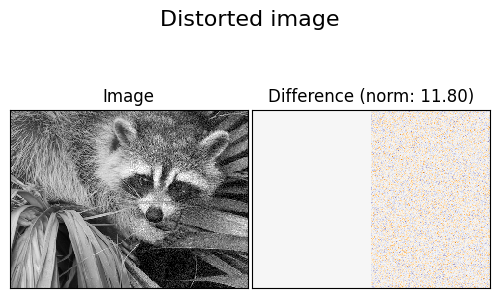

Extracting reference patches...\
22692 patches extracted in 0.02s.

Learning the dictionary...\
1.0 iterations / 107 steps in 27.44.

Patch size : $7\times7$ \
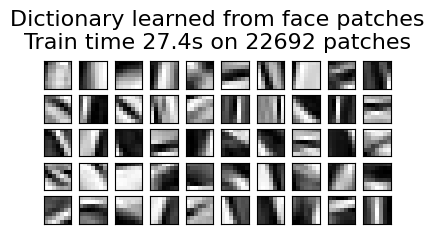

* Extracting noisy patches... \
done in 0.01s.

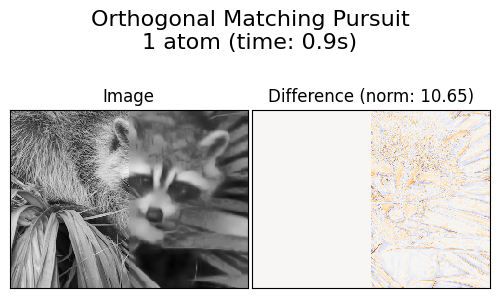
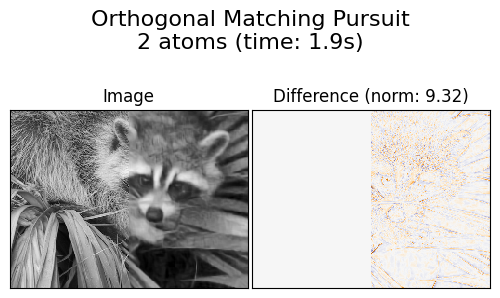
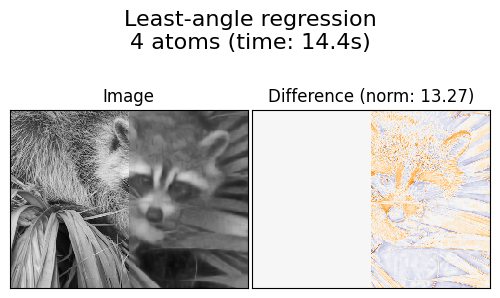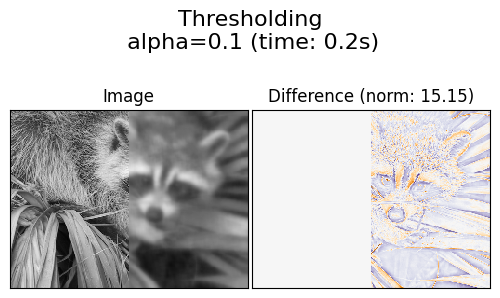

In the downloaded notebok, keeping the number of atoms used fixed, change the patch size to $14\times 14$.  Report any differences in the results and try to explain them:

Extracting reference patches...\
20585 patches extracted in 0.11s.

Learning the dictionary...\
2.0 iterations / 133 steps in 54.73.

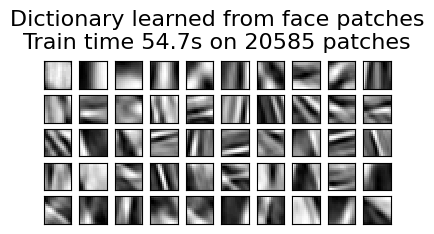

* Extracting noisy patches... \
done in 0.02s.


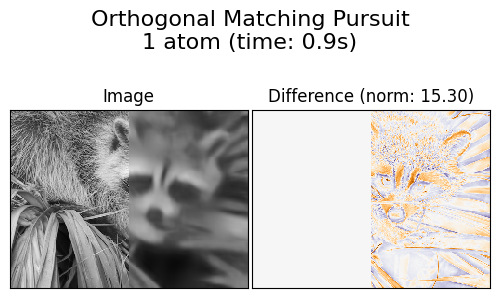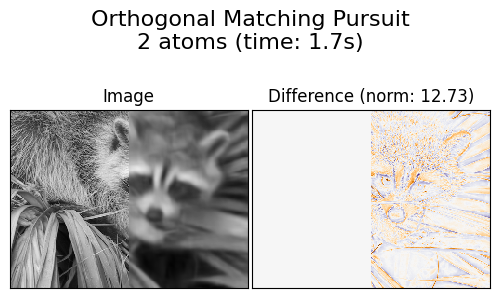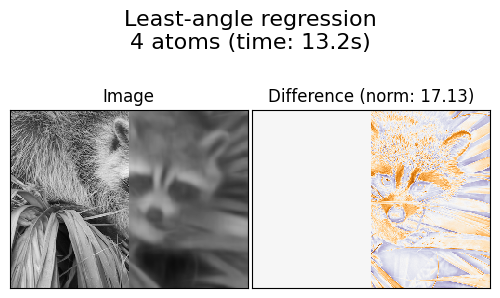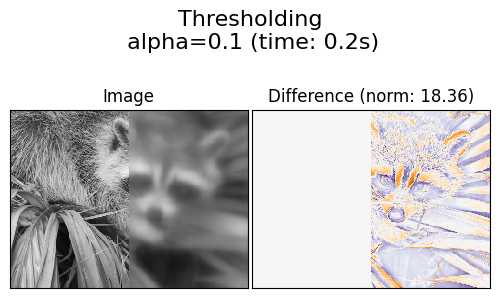

* The number of extracted patches is reduced: Since the patches of $14\times 14$ are larger and there is less overlap between them, the number of extracted patches is reduced.

* Increased computing time: Since larger patches require more computing resources, overall computing time may increase. This is a trade-off, requiring more time to process each larger patch.

* The image is blurrier: larger patches contain wider local information, making the learned dictionary more inclined to capture the overall structure of the image and ignore details.

In the downloaded notebok, keeping the number of atoms used fixed, change the patch size to $3\times 3$.  Report any differences in the results and try to explain them:

Extracting reference patches...\
23940 patches extracted in 0.01s.

Learning the dictionary...\
1.0 iterations / 101 steps in 12.18.

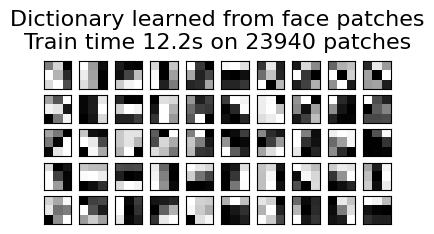

Extracting noisy patches... \
done in 0.01s.

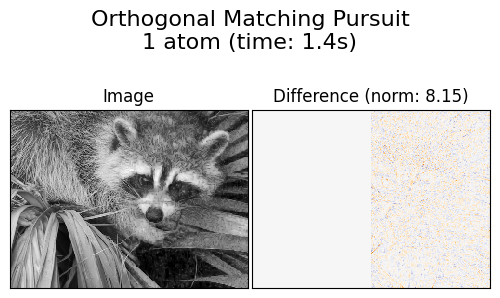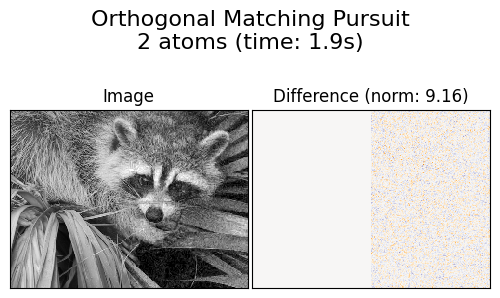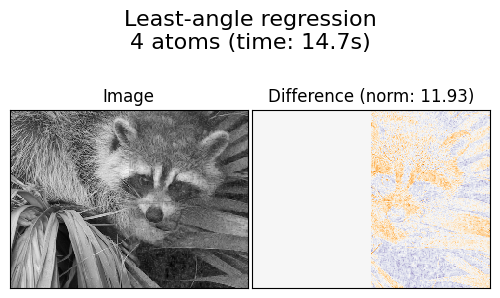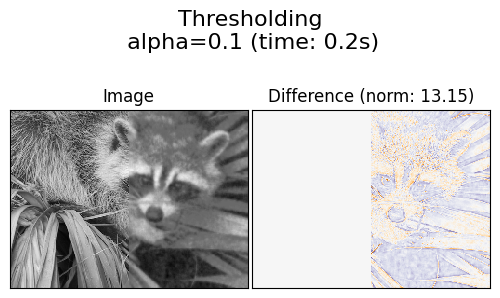

* Increased number of extracted patches: Since the smaller $3 \times 3$ patches are relatively smaller, there is more overlap between them, resulting in an increased number of extracted patches. The information between each patch may be more compact, but at the same time more complex. At the same time, smaller patch size will reduce the atoms required to reconstruct the image. It can be found that the F_norm of the reconstructed image using 1 atom is smaller than that of 2.

* Reduced computation time: Since smaller patches generally require fewer computing resources to process, overall computation time is reduced. Small patches are easier to deal with than larger patches.

* Clearer images: Smaller patches help learn more local detail information, making the learned dictionary pay more attention to the local structure of the image. This enables the learned dictionary to better capture the detailed features of the image.

In the downloaded notebok, keeping the patch size fixed to 7, change the number of atoms used to 1 and 10 (instead of 2).  Report any differences in the results and try to explain them:

Extracting reference patches...\
22692 patches extracted in 0.02s.

Learning the dictionary...\
1.0 iterations / 111 steps in 27.88.


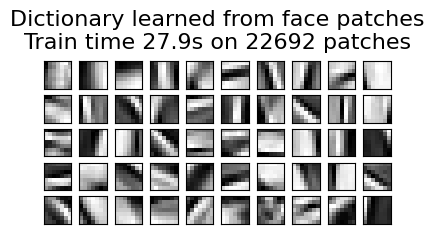

Extracting noisy patches... \
done in 0.01s.

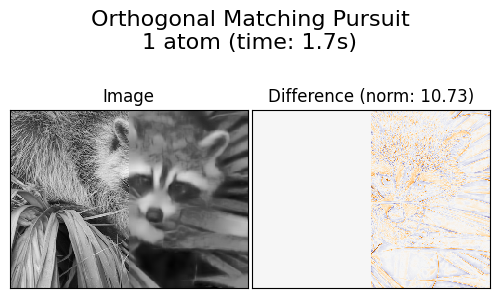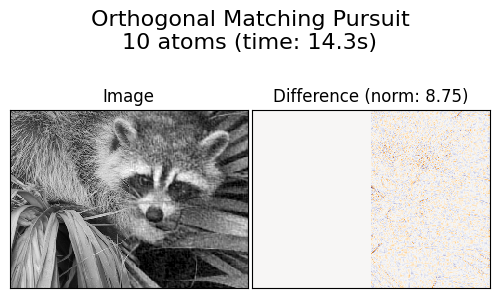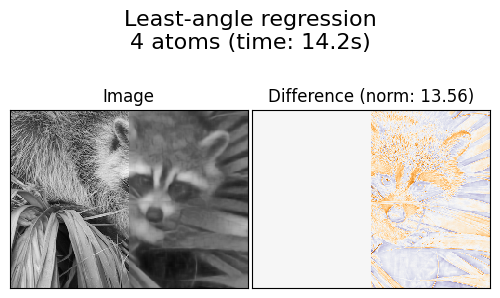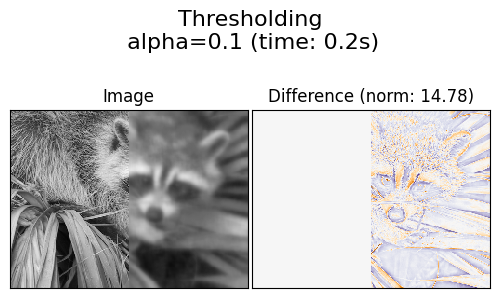

* The number of atomic coefficients is 10:\
Compared with the original code, the number of atomic coefficients used is increased to 10, which means that each patch is allowed to be represented by up to 10 atoms during reconstruction. Since more atoms can be used per patch, the reconstruction results are more complex, better capture the rich structure and details in the image, and are closer to the original image. Because more atoms are used to reconstruct the image, the calculation time increases significantly.

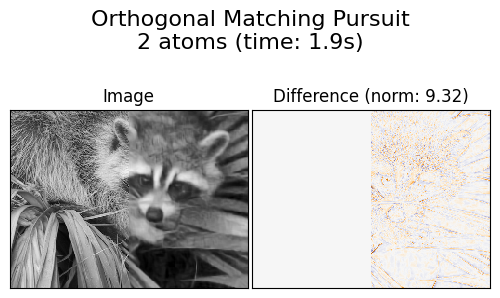
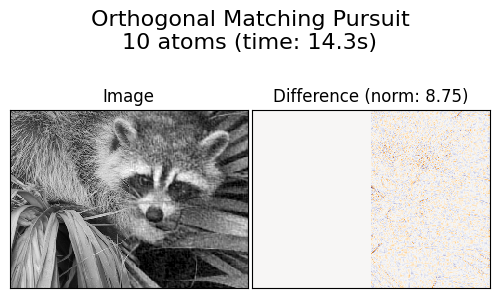

Compared with the case of using 2 atoms's F-norm, the case of using 10 atoms is smaller, indicating that using more atoms can better approximate the original image and reduce the difference between the reconstructed image and the original image.

In the downloaded notebok, keeping the patch size fixed to 7, and using the original number of atoms, change the batch size to 300.  Report any differences in the results and try to explain them:

* Learning the dictionary...\
  2.0 iterations / 120 steps in 15.15.
* Learning the dictionary...\
  2.0 iterations / 98 steps in 17.21.

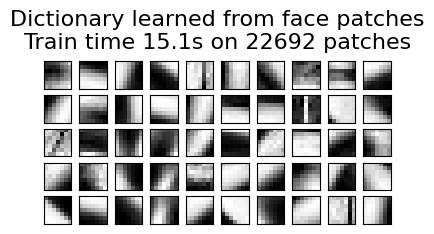
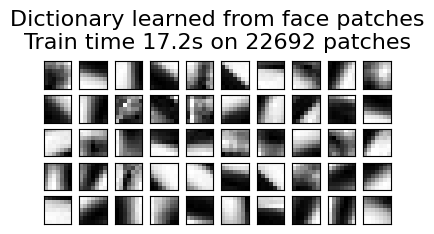

Extracting noisy patches... \
done in 0.01s.

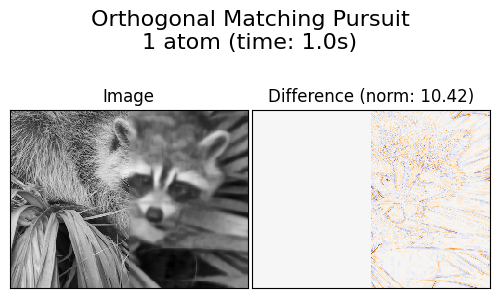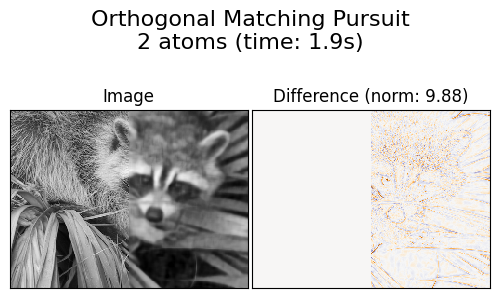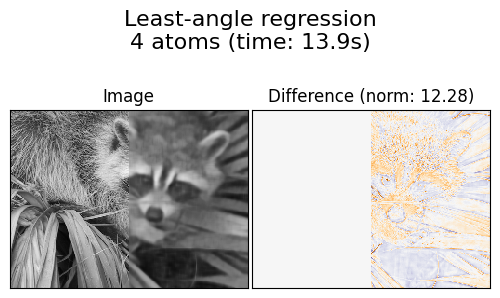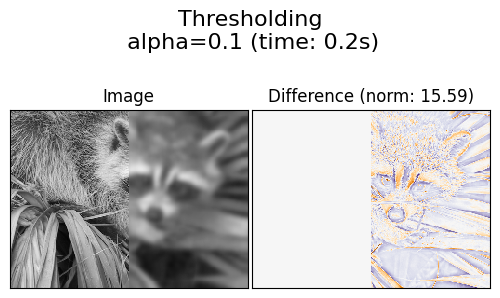

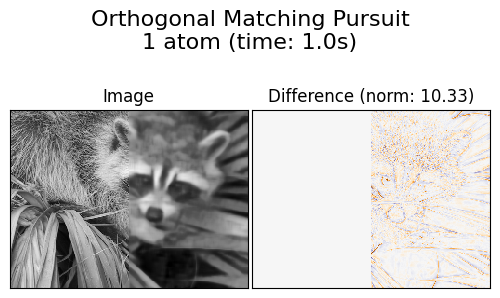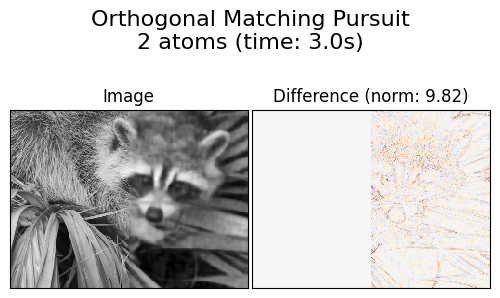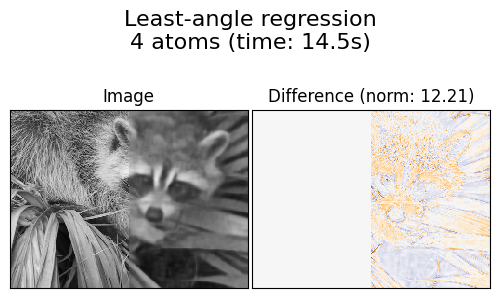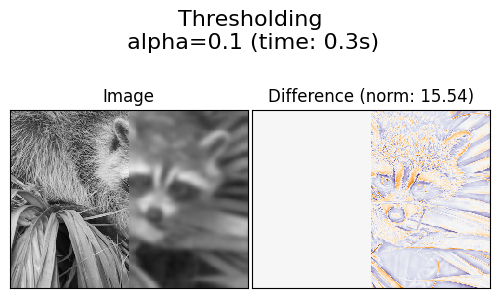

Increasing the batch size ($200\to300$) will cause learning the dictionary to be slower because each update requires more samples. Increased computational burden per batch. Although slower, it reduces noise more, with F-norm reduced by $0.06-0.09$.

Relative to the prior four problems, what parameter choices give you the smallest difference in the image denoising?  Explain your reasoning behind your choices:

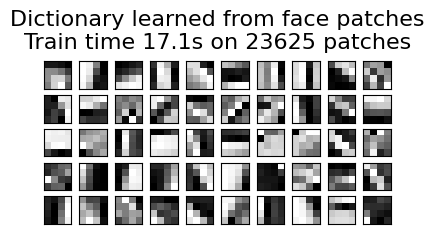

* Using a smaller patch size may help better capture the detailed features of the image, so choose a smaller patch size. However, a patch size that is too small may reduce the choice of the number of atoms when reconstructing the image, so the patch size cannot be too small. After experiments, it was found that when the patch size is $(4,4)$, the phenomenon of using more atoms to reconstruct the image will not lead to greater errors prematurely. Therefore I choose the patch size to be $(4,4)$.

* The improvement obtained by increasing the batch size will have a small increase in computing cost, so the batch size can be increased smaller, such as $300$.


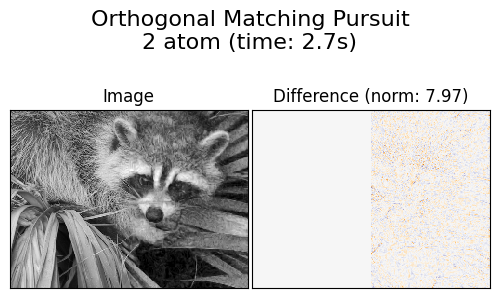

* Based on the comparison, under the previous premise, select $2$ atoms with the smallest F-norm, which are closest to the original image.